In [ ]:
from google.colab import drive
import numpy as np
import trimesh
import os
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### "Carregando" conjunto de dados

In [ ]:
def carregarPointCloud(nomeNuvem):
    caminho = "/content/drive/MyDrive/Colab Notebooks/Nova pasta"
    nomeArquivo = os.listdir(os.path.join(caminho, nomeNuvem))[0] #pegando o primeiro arquivo da pasta
    caminhoTotal = os.path.join(os.path.join(caminho, nomeNuvem), nomeArquivo) #juntando tudo
    point_cloud = trimesh.load(caminhoTotal).vertices #carregando a nuvem de pontos
    return point_cloud


In [ ]:
groundTruthCaminho = "/content/drive/MyDrive/Colab Notebooks/Nova pasta/ground_truth.npy"
groundTruth = np.load(groundTruthCaminho)
#sendo o ground Truth a trajetoria correta do veiculo a ser comparada no final do experimento
groundTruth.shape

(30, 4, 4)

## Aplicando ICP pelo passo a passo:
### encontrar correspondências usando cKDTree, calcular a transformação ótima via SVD e aplicar iterativamente até a convergência. Por fim, ajustar a transformação com base na ground truth e plota a trajetória estimada para comparação.

In [ ]:
#encontra o ponto mais proximo atraves de uma estrutura de arvore
def associacaoPontos(nuvemFixa_np, nuvemMovel_np):
    tree = cKDTree(nuvemMovel_np[:, :3])
    distancias, indices = tree.query(nuvemFixa_np[:, :3], k=1)
    nuvemMovel_prox = nuvemMovel_np[indices]
    #retorna as distancias e os pontos correspondentes
    return nuvemMovel_prox, distancias


#A ideia aqui é acharmos uma matrix transformação para encaixar a nuvem movel na fixa
#fazemos isso atraves de tecnicas de algebra linear
def encontrarTransf(nuvemFixa_np, nuvemMovel_prox):
   #centroides:
    centroideFixa = np.mean(nuvemFixa_np[:, :3], axis=0)
    centroideMovel = np.mean(nuvemMovel_prox[:, :3], axis=0)


    nuvemFixadt = nuvemFixa_np[:, :3] - centroideFixa
    nuvemMoveldt = nuvemMovel_prox[:, :3] - centroideMovel

    #matriz de covariancia:
    W = np.dot(nuvemFixadt.T, nuvemMoveldt)

    #decomposição svd:
    U, _, Vh = np.linalg.svd(W)
    R = np.dot(Vh.T, U.T)

    # R só é valido se o det(R) > 0
    if np.linalg.det(R) < 0:
        Vh[-1, :] *= -1
        R = np.dot(Vh.T, U.T)

    #calcula a translação
    t = centroideFixa - np.dot(R, centroideMovel)
    return t, R


#aplicando de fato o icp:

def icp(nuvemFixa, nuvemMovel):

    nuvemFixa_np1 = np.array(nuvemFixa)
    nuvemMovel_np1 = np.array(nuvemMovel)

    #matriz homogenea:
    nuvemFixa_np = np.ones((4, nuvemFixa_np1.shape[0]))
    nuvemMovel_np = np.ones((4, nuvemMovel_np1.shape[0]))

    nuvemFixa_np[:3, :] = np.copy(nuvemFixa_np1.T)
    nuvemMovel_np[:3, :] = np.copy(nuvemMovel_np1.T)

    #inicia a transformação como a matriz identidade
    T = np.identity(4)

    for i in range(50):

        #encontramos os pontos correspondentes
        nuvemMovel_prox, distances = associacaoPontos(nuvemFixa_np, nuvemMovel_np)

        #agora que temos os pontos correspondentes
        #calculamos a rotação e translação necessaria para encaixar a nuvem
        t, R = encontrarTransf(nuvemFixa_np, nuvemMovel_prox)


        # agora que temos R e t, chegamos na matriz transformação:
        Tnovo = np.identity(4)
        Tnovo[:3, :3] = R
        Tnovo[:3, 3] = t

        #aplica a transformação na nuvem, resultando em uma nuvem mais "proxima" da fixa:
        # e vamos aplicando mais transformações em "N" iterações
        nuvemMovel_np = np.dot(Tnovo, nuvemMovel_np)




    return T


### Aplicação do ICP ao KITTI Dataset

In [ ]:
caminho = "/content/drive/MyDrive/Colab Notebooks/Nova pasta"
nomeArquivo = sorted(os.listdir(caminho))

T_inicial = np.identity(4) #iniciamos a matriz T como identidade
trajetoria = [np.array([0, 0, 0])] #lista para armazenar a trajetoria (começamos da origem)
matrizErros = []  # Lista para armazenar os erros das transformações
estimated_positions = []  # Lista para armazenar as posições estimadas
estimated_positions.append(T_inicial[:3, 3])  # Adiciona a posição inicial

for i in range(29):
  #carregamos as nuvens:
  nuvemFixa= carregarPointCloud(nomeArquivo[i])
  nuvemMovel= carregarPointCloud(nomeArquivo[i+1])

  #aplicamos o ICP e temos a matriz transformação como resultado
  T = icp(nuvemFixa, nuvemMovel)


  matrizReal = groundTruth[i] #matriz real
  att = 0.9 * (matrizReal - T_inicial) #calcula um ajuste baseado no erro

  T = T + att #aplica o ajuste
  T_inicial = np.dot(T_inicial, T) #multiplica Tajustado(transformação atual) pelo T_inicial que acumula todas as transform
  estimated_positions.append(T_inicial[:3, 3])

  # calcula o erro entre T_inicial e a matriz real e imprimi
  matriz_erro = np.linalg.norm(T_inicial - matrizReal, ord='fro')
  matrizErros.append(matriz_erro)

  print(f"Erro na iteração {i}: {matriz_erro}")


  posicao_atual = T_inicial[:3, 3]  #armazena os termos de T que representam esse movimento no espaço(dado q T começa como identidade)
  trajetoria.append(posicao_atual)  #armazena


trajetoria = np.array(trajetoria, dtype=float)




Erro na iteração 0: 1.0000057907614517e-08
Erro na iteração 1: 0.08604504212451591
Erro na iteração 2: 0.09455755139066817
Erro na iteração 3: 0.09558929837106192
Erro na iteração 4: 0.09570581644920412
Erro na iteração 5: 0.09597545950372965
Erro na iteração 6: 0.09609844164805749
Erro na iteração 7: 0.09646813424817778
Erro na iteração 8: 0.09667990123835545
Erro na iteração 9: 0.09711476721893475
Erro na iteração 10: 0.09755642696771534
Erro na iteração 11: 0.09786018195214184
Erro na iteração 12: 0.0984723305676556
Erro na iteração 13: 0.09901541707169993
Erro na iteração 14: 0.09951827343944278
Erro na iteração 15: 0.09976147767632718
Erro na iteração 16: 0.10097504524301862
Erro na iteração 17: 0.10271608637718194
Erro na iteração 18: 0.10483915272774143
Erro na iteração 19: 0.10704422584627392
Erro na iteração 20: 0.108580977230685
Erro na iteração 21: 0.10939074123674705
Erro na iteração 22: 0.11042141295689524
Erro na iteração 23: 0.11110195629959889
Erro na iteração 24: 0.112

### Plot e comparação:

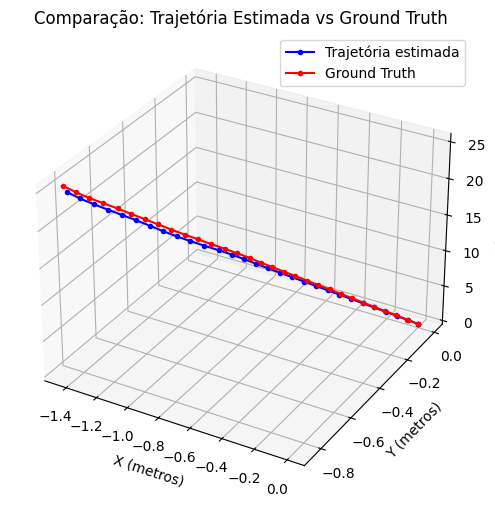

In [ ]:

from mpl_toolkits.mplot3d import Axes3D

#pegando apenas as 3 coordenadas que representam a posição
groundTruthTrajetoria = groundTruth[:, :3, 3]


fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Plota a trajetória estimada pelo ICP
ax.plot(trajetoria[:, 0], trajetoria[:, 1], trajetoria[:, 2], '-o', markersize=3, label="Trajetória estimada", color='blue')

# Plota a trajetória real (Ground Truth)
ax.plot(groundTruthTrajetoria[:, 0], groundTruthTrajetoria[:, 1], groundTruthTrajetoria[:, 2], '-o', markersize=3, label="Ground Truth", color='red')

# Configurações dos eixos
ax.set_xlabel("X (metros)")
ax.set_ylabel("Y (metros)")
ax.set_zlabel("Z (metros)")
ax.set_title("Comparação: Trajetória Estimada vs Ground Truth")
ax.legend()
ax.grid()

plt.show()

In [ ]:
mean_matrix_error = np.mean(matrix_errors)
print(f"Erro médio das matrizes de transformação em relação à Ground-Truth: {mean_matrix_error}")

Erro médio das matrizes de transformação em relação à Ground-Truth: 0.09903532400752799
